In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import joblib

# 1️⃣ Baca dataset
df = pd.read_csv("Mental_Health_and_Social_Media_Balance_Dataset.csv")


In [43]:
# 2️⃣ Buat kolom kategori target
def happiness_category(x):
    if x <= 4:
        return "Low"
    elif x <= 7:
        return "Medium"
    else:
        return "High"

df['Happiness_Level'] = df['Happiness_Index(1-10)'].apply(happiness_category)

In [44]:
# 3️⃣ Hapus kolom target dari fitur
X = df.drop(columns=['User_ID', 'Happiness_Index(1-10)', 'Happiness_Level'])
y = df['Happiness_Level']


In [45]:
# 4️⃣ Ubah semua kolom teks menjadi angka
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])

In [47]:
# 5️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
# 6️⃣ Buat model Decision Tree
modelB = DecisionTreeClassifier(max_depth=4, random_state=42)
modelB.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [49]:
# 7️⃣ Simpan model untuk Flask
joblib.dump(modelB, "model_decision_tree.pkl")

print("✅ Model berhasil dilatih & disimpan tanpa error!")
print("Kolom yang digunakan untuk fitur:")
print(list(X.columns))

✅ Model berhasil dilatih & disimpan tanpa error!
Kolom yang digunakan untuk fitur:
['Age', 'Gender', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)', 'Days_Without_Social_Media', 'Exercise_Frequency(week)', 'Social_Media_Platform']


In [50]:
modelA = DecisionTreeClassifier(random_state=42)
modelA.fit(X_train, y_train)
y_predA = modelA.predict(X_test)

print("\n=== Model A: Tanpa Pruning ===")
print(confusion_matrix(y_test, y_predA))
print(classification_report(y_test, y_predA))



=== Model A: Tanpa Pruning ===
[[62  0  8]
 [ 0  1  0]
 [11  2 16]]
              precision    recall  f1-score   support

        High       0.85      0.89      0.87        70
         Low       0.33      1.00      0.50         1
      Medium       0.67      0.55      0.60        29

    accuracy                           0.79       100
   macro avg       0.62      0.81      0.66       100
weighted avg       0.79      0.79      0.79       100



In [51]:
modelB = DecisionTreeClassifier(max_depth=4, random_state=42)
modelB.fit(X_train, y_train)
y_predB = modelB.predict(X_test)

print("\n=== Model B: Dengan Pruning (max_depth=4) ===")
print(confusion_matrix(y_test, y_predB))
print(classification_report(y_test, y_predB))



=== Model B: Dengan Pruning (max_depth=4) ===
[[66  0  4]
 [ 0  0  1]
 [16  1 12]]
              precision    recall  f1-score   support

        High       0.80      0.94      0.87        70
         Low       0.00      0.00      0.00         1
      Medium       0.71      0.41      0.52        29

    accuracy                           0.78       100
   macro avg       0.50      0.45      0.46       100
weighted avg       0.77      0.78      0.76       100



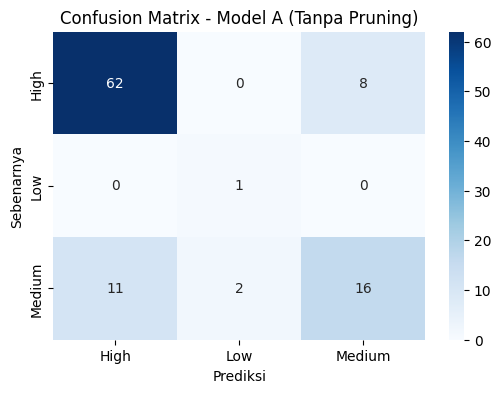

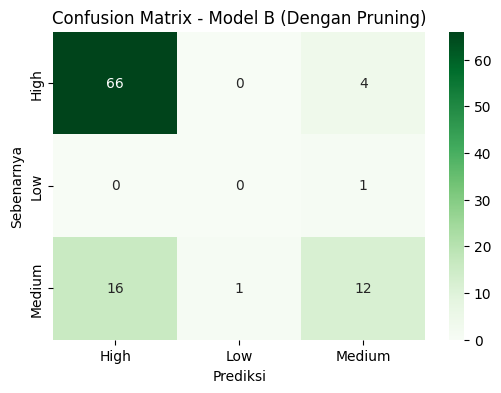

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ===================================================
# 🔷 Confusion Matrix untuk Model A (Tanpa Pruning)
# ===================================================
cm_A = confusion_matrix(y_test, y_predA)

plt.figure(figsize=(6,4))
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues',
            xticklabels=modelA.classes_,
            yticklabels=modelA.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix - Model A (Tanpa Pruning)')
plt.show()

# ===================================================
# 🔶 Confusion Matrix untuk Model B (Dengan Pruning)
# ===================================================
cm_B = confusion_matrix(y_test, y_predB)

plt.figure(figsize=(6,4))
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Greens',
            xticklabels=modelB.classes_,
            yticklabels=modelB.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix - Model B (Dengan Pruning)')
plt.show()


In [53]:
# 6️⃣ Simpan model untuk Flask
joblib.dump(modelB, "model_decision_tree.pkl")

['model_decision_tree.pkl']

In [54]:
print("✅ Model sudah dilatih & disimpan tanpa kolom target!")
print("Fitur yang digunakan:", list(X.columns))

✅ Model sudah dilatih & disimpan tanpa kolom target!
Fitur yang digunakan: ['Age', 'Gender', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)', 'Days_Without_Social_Media', 'Exercise_Frequency(week)', 'Social_Media_Platform']


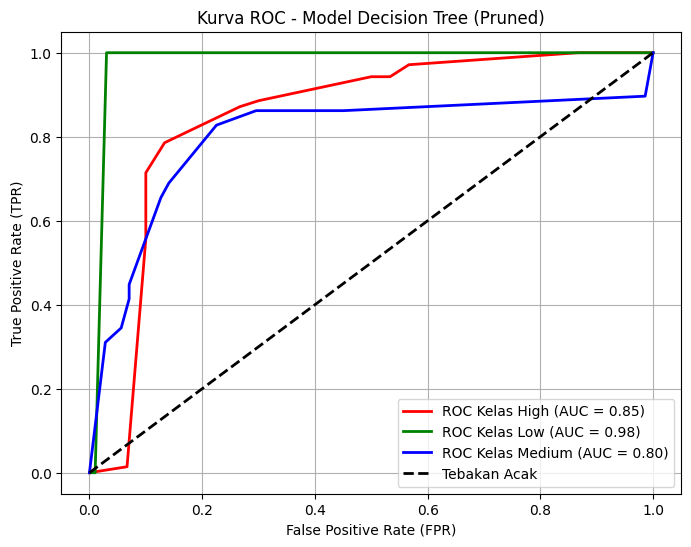

Rata-rata AUC untuk semua kelas: 0.889


In [55]:
# ===================================================
# 🔷 ROC Curve (Receiver Operating Characteristic)
# ===================================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import numpy as np

# Konversi label ke bentuk biner (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=modelB.classes_)
y_pred_proba = modelB.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Hitung FPR, TPR untuk tiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ===================================================
# 🔶 Plot ROC Curve
# ===================================================
plt.figure(figsize=(8,6))
colors = cycle(['red', 'green', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC Kelas {modelB.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Tebakan Acak')
plt.title('Kurva ROC - Model Decision Tree (Pruned)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ===================================================
# Nilai AUC Rata-rata
# ===================================================
mean_auc = np.mean(list(roc_auc.values()))
print(f"Rata-rata AUC untuk semua kelas: {mean_auc:.3f}")


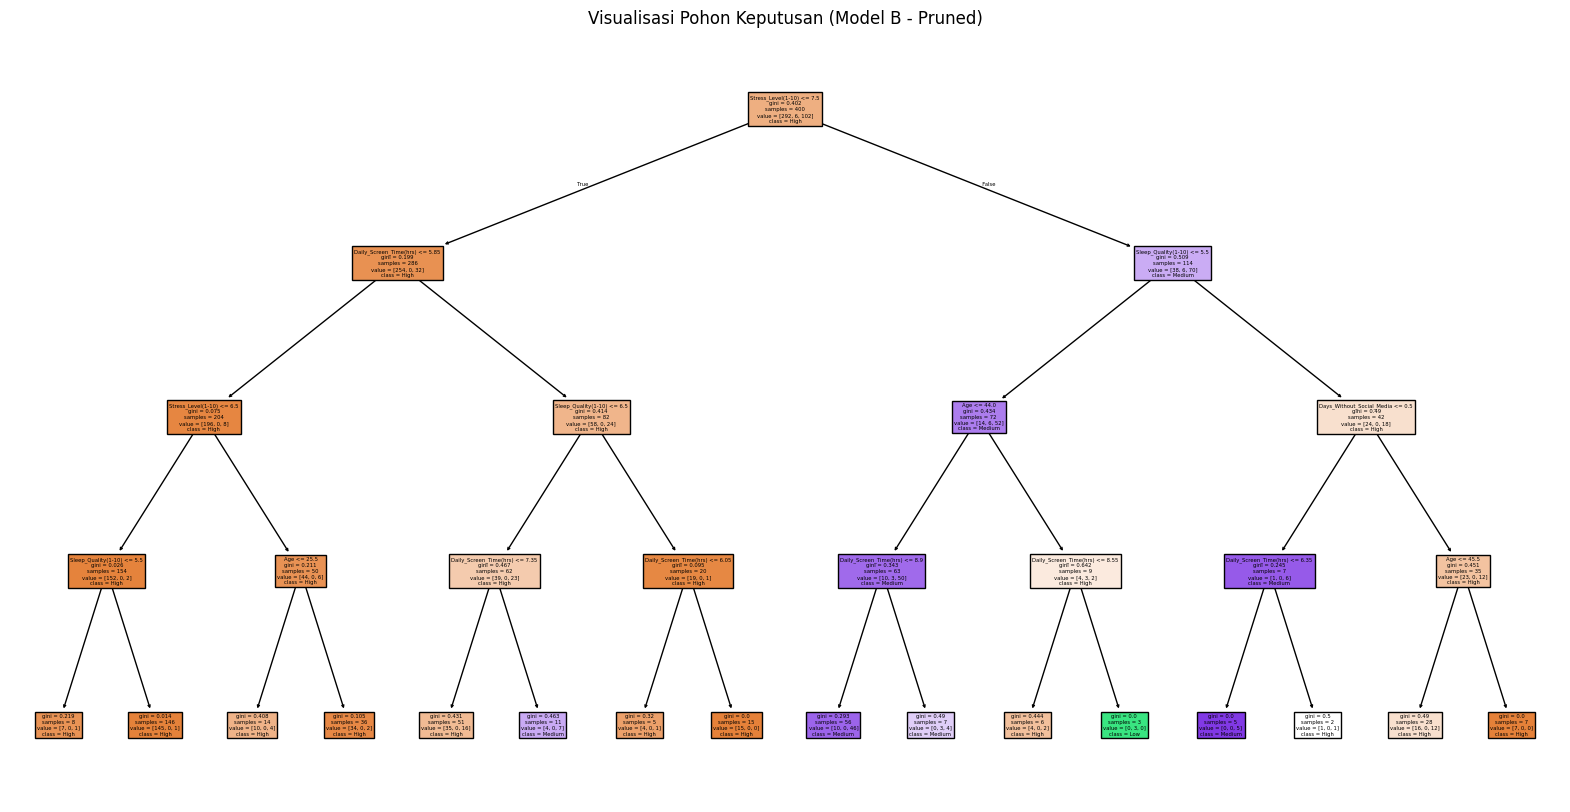

In [56]:

plt.figure(figsize=(20,10))
plot_tree(
    modelB,
    filled=True,
    feature_names=X.columns,
    class_names=[str(c) for c in modelB.classes_]  # ubah class jadi string
)
plt.title("Visualisasi Pohon Keputusan (Model B - Pruned)")
plt.show()


C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_420\3535833373.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pentingnya', y='Fitur', data=importances, palette='viridis')


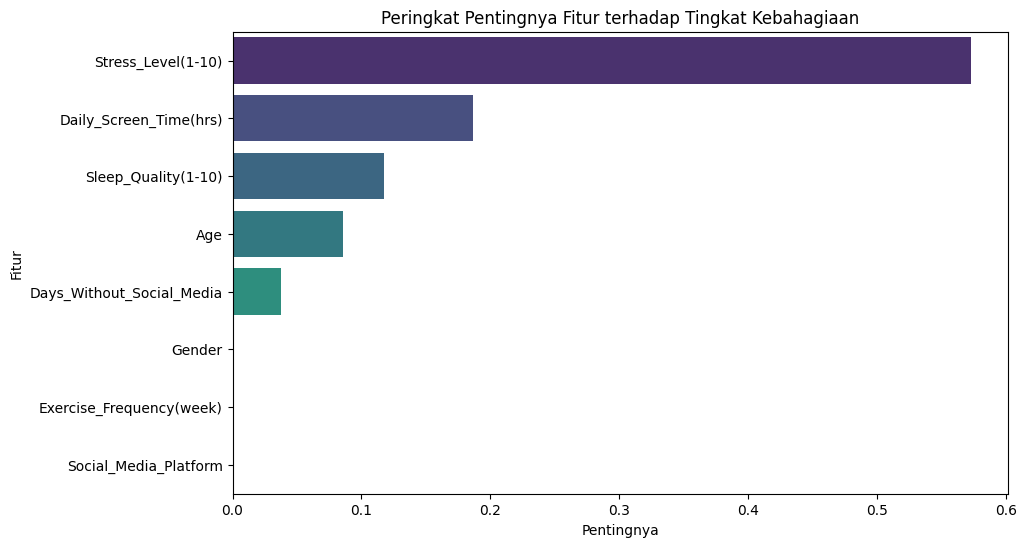

In [57]:
importances = pd.DataFrame({
    'Fitur': X.columns,
    'Pentingnya': modelB.feature_importances_
}).sort_values(by='Pentingnya', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Pentingnya', y='Fitur', data=importances, palette='viridis')
plt.title('Peringkat Pentingnya Fitur terhadap Tingkat Kebahagiaan')
plt.show()

In [58]:

# 9️⃣ Kesimpulan

print("""
Kesimpulan:
- Dataset digunakan untuk memprediksi tingkat kebahagiaan berdasarkan keseimbangan media sosial dan gaya hidup.
- Model A (tanpa pruning) cenderung overfitting.
- Model B (max_depth=4) lebih seimbang dan mudah dijelaskan.
- Faktor paling berpengaruh biasanya adalah tingkat stres, durasi tidur, dan waktu di media sosial.
""")




Kesimpulan:
- Dataset digunakan untuk memprediksi tingkat kebahagiaan berdasarkan keseimbangan media sosial dan gaya hidup.
- Model A (tanpa pruning) cenderung overfitting.
- Model B (max_depth=4) lebih seimbang dan mudah dijelaskan.
- Faktor paling berpengaruh biasanya adalah tingkat stres, durasi tidur, dan waktu di media sosial.

